In [1]:
import numpy as np

In [2]:
import struct
from array import array
from os.path import join
import matplotlib.pyplot as plt
import random

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)
    
def show_images(images, title_texts):
    cols = 3
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(20,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

training_images_filepath = "mnist_dataset/train-images.idx3-ubyte"
training_labels_filepath = "mnist_dataset/train-labels.idx1-ubyte"
test_images_filepath = "mnist_dataset/t10k-images.idx3-ubyte"
test_labels_filepath = "mnist_dataset/t10k-labels.idx1-ubyte"

In [3]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

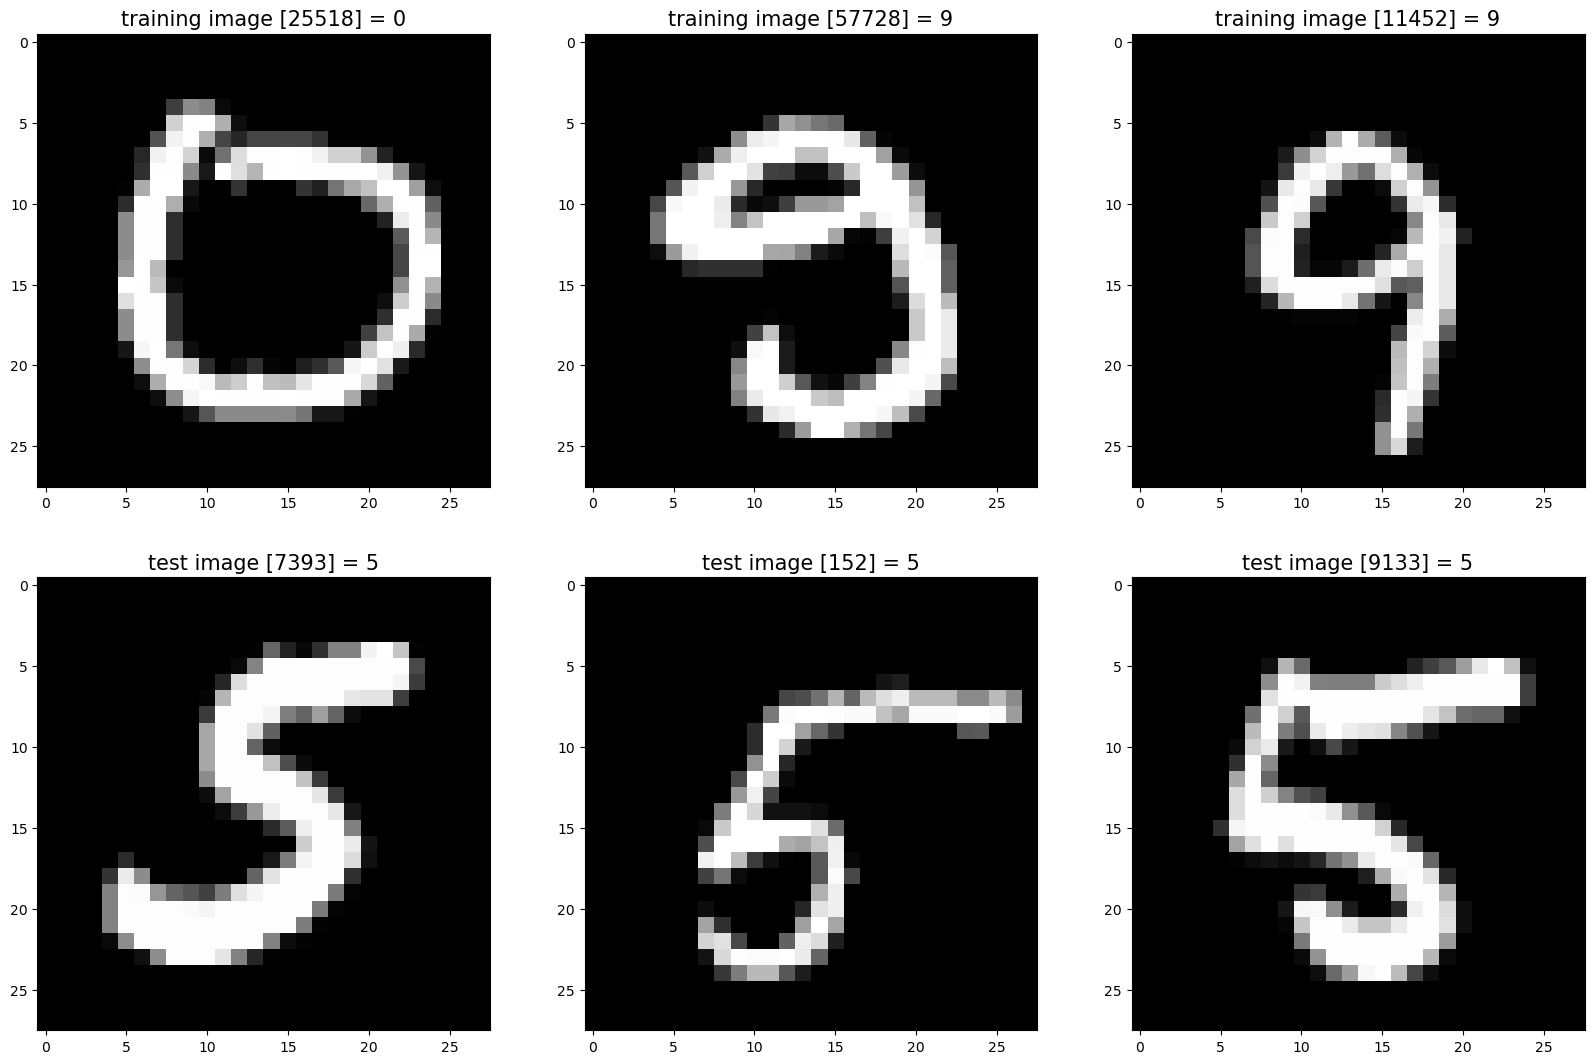

In [5]:
images_2_show = []
titles_2_show = []
number_of_images_to_show = 3
# 3 random training images
for i in range(0, number_of_images_to_show):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

# 3 random test images
for i in range(0, number_of_images_to_show):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [6]:
def preprocess(x_train, x_test):
	x_train = np.array(x_train)
	x_test = np.array(x_test)
	x_train = x_train/255
	x_test = x_test/255
	x_train = x_train.reshape(x_train.shape[0], -1, 1)
	x_test = x_test.reshape(x_test.shape[0], -1, 1)
	return x_train, x_test

x_train, x_test = preprocess(x_train, x_test)
print(x_train.shape)

(60000, 784, 1)


In [7]:
def one_hot(y_train, y_test):
	y_train = np.array(y_train)
	y_test = np.array(y_test)
	y_train = np.eye(10)[y_train]
	y_test = np.eye(10)[y_test]
	y_train = y_train.reshape(y_train.shape[0], -1, 1)
	y_test = y_test.reshape(y_test.shape[0], -1, 1)
	return y_train, y_test

y_train, y_test = one_hot(y_train, y_test)

## Building the neural network

In [8]:
n = (784, 128, 32, 10) 
epochs = 10 
lr = 0.01

In [26]:
from tqdm import tqdm

class NN:
	def __init__(self, n, epochs, lr):
		self.n = n
		self.epochs = epochs
		self.lr = lr

		self.input_layer = n[0]
		self.hidden_layer1 = n[1]
		self.hidden_layer2 = n[2]
		self.output_layer = n[3]

		self.params = {
			'W1': np.random.randn(self.hidden_layer1, self.input_layer) * np.sqrt(1. / self.hidden_layer1),
			'W2': np.random.randn(self.hidden_layer2, self.hidden_layer1) * np.sqrt(1. / self.hidden_layer2),
			'W3': np.random.randn(self.output_layer, self.hidden_layer2) * np.sqrt(1. / self.output_layer),
			'b1': np.zeros((self.hidden_layer1, 1)),
			'b2': np.zeros((self.hidden_layer2, 1)),
			'b3': np.zeros((self.output_layer, 1))
		}

	def sigmoid(self, x, derivative=False):
		if (derivative):
			return np.exp(-x) / ((1 + np.exp(-x)) ** 2)
		return 1 / (1 + np.exp(-x))
	
	def softmax(self, x, derivative=False):
		e_x = np.exp(x - np.max(x)) 
		if derivative:
			return e_x / e_x.sum(axis=0) * (1 - e_x / e_x.sum(axis=0))
		return e_x / e_x.sum(axis=0)

	def feed_forward(self, image):
		params = self.params

		params['a0'] = image

		params['z1'] = np.matmul(params['W1'], image) + params['b1']
		params['a1'] = self.sigmoid(params['z1'])

		params['z2'] = np.matmul(params['W2'], params['a1']) + params['b2']
		params['a2'] = self.sigmoid(params['z2'])
		
		params['z3'] = np.matmul(params['W3'], params['a2']) + params['b3']
		params['a3'] = self.softmax(params['z3'])

		return params['a3']

	def loss(self, output_label, true_label):
		return np.sum(0.5 * (output_label - true_label) ** 2)
	
	def back_propagation(self, output, y_true):
		params = self.params

		change_w = {}
		change_b = {}

		error = (output - y_true) * self.softmax(params['z3'], derivative=True)
		change_w['W3'] = np.outer(error, params['a2'])
		change_b['b3'] = error

		error = np.dot(params['W3'].T, error) * self.sigmoid(params['z2'], derivative=True)
		change_w['W2'] = np.outer(error, params['a1'])
		change_b['b2'] = error

		error = np.dot(params['W2'].T, error) * self.sigmoid(params['z1'], derivative=True)
		change_w['W1'] = np.outer(error, params['a0'])
		change_b['b1'] = error

		return change_w, change_b
	
	def update_weights(self, change_w, change_b):
		params = self.params
		params['W3'] -= self.lr * change_w['W3']
		params['b3'] -= self.lr * np.sum(change_b['b3'], axis=0)

		params['W2'] -= self.lr * change_w['W2']
		params['b2'] -= self.lr * np.sum(change_b['b2'], axis=0)

		params['W1'] -= self.lr * change_w['W1']
		params['b1'] -= self.lr * np.sum(change_b['b1'], axis=0)

	def train(self, x_train, y_train) -> None:
		for i in range(self.epochs):
			for image, label in tqdm(zip(x_train, y_train), total=len(x_train), desc=f'Epoch {i+1}/{self.epochs}'):
				pred = self.feed_forward(image)
				change_w, change_b = self.back_propagation(pred, label)
				self.update_weights(change_w, change_b)

	def predict(self, x_test : np.array) -> np.array:
		predictions = np.array([])
		for image in x_test:
			pred = self.feed_forward(image)
			pred = np.argmax(pred)
			predictions = np.append(predictions, pred)

		return predictions
	
	def accuracy(self, y_test, y_pred):
		count = 0
		y_true = y_test.reshape(y_test.shape[0], -1)
		y_true = np.argmax(y_true, axis=1)
		for i in range(len(y_true)):
			if y_true[i] == y_pred[i]:
				count += 1
		return count / len(y_true)

In [27]:
nn = NN(n, epochs, lr)

In [28]:
nn.train(x_train, y_train)

Epoch 10/10: 100%|██████████| 60000/60000 [01:20<00:00, 748.13it/s] 


In [12]:
y_pred = nn.predict(x_test)

In [ ]:
print(nn.accuracy(y_test, y_pred)*100)

0.942
